## **Importing libraries**
Here're some libraries required to operate this project

In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib
import ast
import cv2 as cv
import imutils
import torch
import torchvision
import torch.optim as optim

In [ ]:
from matplotlib import pyplot as plt
from torch import nn
from torchvision import datasets, models, transforms
from torchvision.transforms import v2

Setting the randomized seed for replication

In [ ]:
np.random.seed(7)
torch.cuda.manual_seed_all(7)
plt.style.use('ggplot')

In [ ]:
%pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=d1f742c57928367ac5b0c0b937b008b8d9ba6fea06b2764e43b125526dcc3fbb
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [ ]:
%%capture
%pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d pkdarabi/brain-tumor-image-dataset-semantic-segmentation

In [ ]:
# Unzipping the dataset
%%capture
!unzip brain-tumor-image-dataset-semantic-segmentation.zip -d brain_images

Image shape: (640, 640, 3)


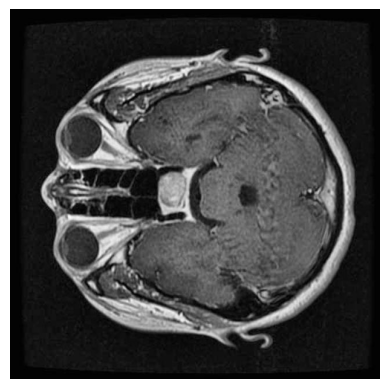

In [ ]:
# Loading a sample image
img = cv.imread("/content/brain_images/train/1000_jpg.rf.1c16148495900a466a53f121ec6af0a9.jpg")
print("Image shape:", img.shape)
plt.imshow(img)
plt.axis("off")
plt.show()

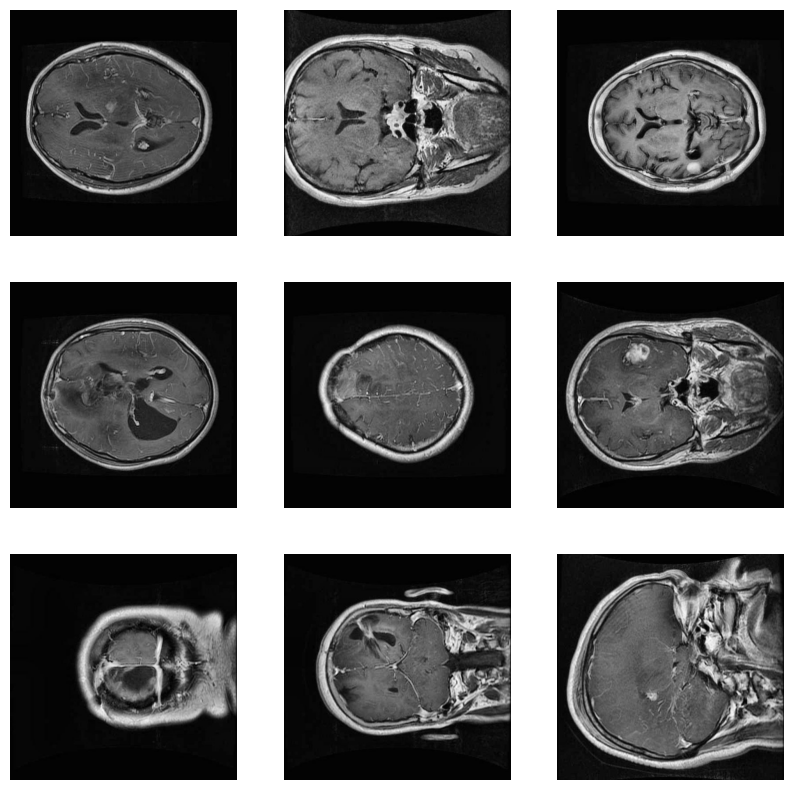

In [ ]:
# Loading images initially in batch:
def load_images(path, nrows, ncols):
  fig, axs = plt.subplots(nrows, ncols, figsize=(10, 10))
  for i, filename in zip(range(nrows * ncols), os.listdir(path)):
    if filename.endswith('.jpg'):
      img_path = os.path.join(path, filename)
      img = matplotlib.image.imread(img_path)
      axs[i // nrows, i % nrows].imshow(img)
      axs[i // nrows, i % nrows].axis('off')
load_images('/content/brain_images/train/', 3, 3)
plt.show()

## **Working With Annotation**

In [ ]:
def read_annotation(img_path):
  """
    This function reads the annotation file and returns its content
    as a list of dictionaries, each dict contains information
    regarding an image
    ----------
    Parameter:
    - img_path (str): the path of the images
    Return:
    - dataset_dict (list): a list of the dataset's annotations
  """
  dataset_dict = []
  with open(f"{img_path}/_annotations.coco.json", "r") as annotation:
    annot = annotation.read()
    annot = ast.literal_eval(annot)
    for image, annotation in list(zip(annot['images'], annot['annotations'])):
      input = {}
      # Assign the image info to the input dict
      input['file_name'] = os.path.join(img_path, image['file_name'])
      input['height'] = image['height']
      input['width'] = image['width']
      input['image_id'] = image['id']

      # Asserting the id is consistent between image information & its annotation
      message = f"Image id is in consistent in image file {input['file_name']}"
      assert input['image_id'] == annotation['id'], message

      # Assign the annotation info to the input dict
      input['category_id'] = annotation['category_id']
      input['bbox'] = annotation['bbox']
      input['area'] = annotation['area']
      input['segmentation'] = annotation['segmentation']
      input['iscrowd'] = annotation['iscrowd']

      dataset_dict.append(input)
    return dataset_dict

In [ ]:
train_annotation = read_annotation("/content/brain_images/train")
val_annotation = read_annotation("/content/brain_images/valid")
test_annotation = read_annotation("/content/brain_images/test")

In [ ]:
# Drawing bbox and segmentation
import random
def viz_image():
  imgs = random.choices(train_annotation, k=2)
  fig, axs = plt.subplots(1, 2, figsize=(10, 10))

  # Plot 2 random imgs
  for i in range(len(imgs)):
    img = imgs[i]
    img_draw = matplotlib.image.imread(imgs[i]['file_name'])
    x, y, width, height = [img['bbox'][x] for x in range(4)]
    rect = plt.Rectangle((x, y), width, height, facecolor="None", linewidth=2, edgecolor="red")
    axs[i].add_patch(rect)
    axs[i].imshow(img_draw)
    axs[i].axis('off')
  plt.show()

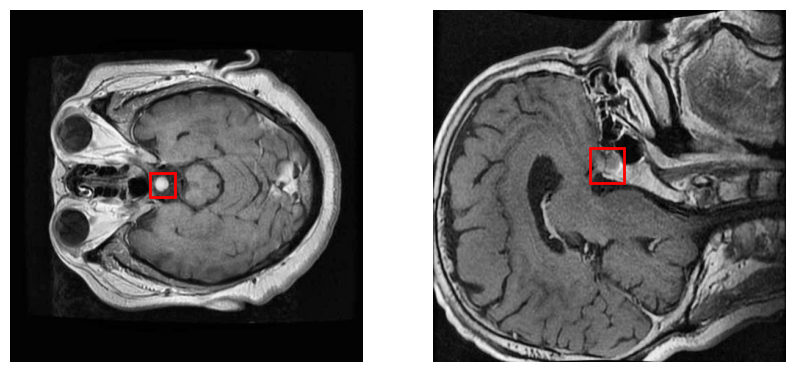

In [ ]:
viz_image()

## **Data Augmentation**
In order to work effectively with the images, we would want to resize them to 240x240x3, as this size is the most proper size for feeding into EfficientNet

In [ ]:
def img_border_crop(img):
  """
    This function crops the image to retain only a rectangle that fills its
    boundaries
    ------------
    Parameter:
    - img (jpg): an img passed to be cropped
    Return:
    - img (jpg): the img cropped
  """
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  img = cv.GaussianBlur(img, (3, 3), 0)

  img = cv.threshold(img, 45, 225, cv.THRESH_BINARY)[1]
  img = cv.erode(img, None, iterations=2)
  img = cv.dilate(img, None, iterations=2)

  cnts = cv.findContours(img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv.contourArea)

  left = tuple(c[c[:, :, 0].argmin()][0])
  right = tuple(c[c[:, :, 0].argmax()][0])
  top = tuple(c[c[:, :, 1].argmin()][0])
  bot = tuple(c[c[:, :, 1].argmax()][0])

  img = img[top[1]:bot[1], left[0]:right[0]]
  return img

def transform_img(img):
  """
  """
  transforms = v2.Compose([
    v2.RandomResizedCrop(size=(240, 240), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  return transforms(img)

def img_load(file_path, annot_file):
  """
  """
  X = []

  for image in os.listdir(file_path):
    if not image.endswith(".json"):
      img_path = os.path.join(file_path, image)
      img = cv.imread(img_path)
      img = img_border_crop(img)

      img = cv.resize(img, dsize=(240, 240), interpolation=cv.INTER_CUBIC)
      # img = transform_img(img)
      img = img / 255
      X.append(img)
  return X

In [ ]:
X_train = img_load("/content/brain_images/train/", train_annotation)
X_val = img_load("/content/brain_images/valid/", val_annotation)
X_test = img_load("/content/brain_images/test/", test_annotation)

## **Dataset Class**

In [ ]:
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
  def __init__(self, img_path):
    self.img_path = img_path
    self.annotations = read_annotation(img_path)

  def __len__(self):
    return len(self.annotations)

  def __getitem__(self, idx):
    annotation = self.annotations[idx]
    img = cv.imread(annotation['file_name'])
    img = img_border_crop(img)
    img = cv.resize(img, dsize=(240, 240), interpolation=cv.INTER_CUBIC)
    img = np.stack((img, )*3, axis = -1)
    img = img / 255.0

    img = torch.from_numpy(img).permute(2, 0, 1)
    labels = {
        'bbox': torch.as_tensor(annotation['bbox'], dtype=torch.float32),
        'category' : None,
    }
    label = annotation['category_id']
    if annotation['category_id'] == 1:
      label = 0
    elif annotation['category_id'] == 2:
      label = 1
    labels['category'] = torch.as_tensor(label, dtype=torch.int64)

    return img, labels

In [ ]:
train_dataset = CustomDataset("/content/brain_images/train/")
X_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = CustomDataset("/content/brain_images/valid/")
X_val = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataset = CustomDataset("/content/brain_images/test/")
X_test = DataLoader(test_dataset, batch_size=32, shuffle=True)

### **Transfer Learning with EfficientNet**

In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
efficientnet = EfficientNet.from_pretrained('efficientnet-b2')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 160MB/s]


Loaded pretrained weights for efficientnet-b2


In [ ]:
for param in efficientnet.parameters():
  param.requires_grad = False

## **Building the model**

In [ ]:
class EfficientNet_Mod(nn.Module):
  def __init__(self, efficientnet):
    super(EfficientNet_Mod, self).__init__()
    self.features = efficientnet
    self.global_avg_pooling = torch.nn.AdaptiveAvgPool2d(1)
    self.dropout = torch.nn.Dropout(0.5)
    self.fc = torch.nn.Linear(efficientnet._fc.in_features, 2)

  def forward(self, x):
    x = self.features.extract_features(x)
    x = self.global_avg_pooling(x)
    x = torch.flatten(x, 1)
    x = self.dropout(x)
    x = self.fc(x)
    return x

modified_efficientnet = EfficientNet_Mod(efficientnet)

In [ ]:
def train_model():
  num_epochs = 10
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(modified_efficientnet.parameters(), lr=0.001)
  modified_efficientnet.train() # switching to train model

  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_predictions = 0.0
    total_samples = 0

    for inputs, labels in X_train:
      true_labels = labels['category']
      inputs = inputs.float()
      optimizer.zero_grad()
      outputs = modified_efficientnet(inputs)
      loss = criterion(outputs, true_labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item() * inputs.size(0)
      _, predicted = torch.max(outputs, 1)
      correct_predictions += (predicted == true_labels).sum().item()
      total_samples += true_labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
train_model()

Epoch [1/10], Loss: 0.6417, Accuracy: 0.6378
Epoch [2/10], Loss: 0.5715, Accuracy: 0.7117
Epoch [3/10], Loss: 0.5540, Accuracy: 0.7264
Epoch [4/10], Loss: 0.5341, Accuracy: 0.7450
Epoch [5/10], Loss: 0.5245, Accuracy: 0.7523


In [ ]:
torch.save(modified_efficientnet.state_dict(), 'model.pth')

## **Model evaluation**

In [ ]:
modified_efficientnet.load_state_dict(torch.load('model.pth'))

In [ ]:
modified_efficientnet.eval()

In [ ]:
# Building a COCOEvaluator
def evaluator():
  return

In [ ]:
# Create predictions